# Example of training DQN network for play games
## Applied an approach of stack of images for inference for DQN
## Combined several methods for generation of Q-target


### Import of libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pygame
import gym
from IPython import display
import tensorflow as tf
import copy
from gym.wrappers.record_video import RecordVideo
import random
import os
import shutil

pygame 2.5.2 (SDL 2.28.2, Python 3.9.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


2024-02-06 17:32:32.241199: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 17:32:32.241220: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 17:32:32.241226: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 17:32:32.245370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Make the game environment.
### Overview of State shape, Actions and their meanings

In [2]:
env = gym.make('Pong-v4', render_mode="rgb_array", obs_type="grayscale")

STATE_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
ACTION_MEANING = env.unwrapped.get_action_meanings()

print('States shape: {}'.format(STATE_SHAPE))
print('Actions: {}'.format(NUM_ACTIONS))
print('Actions: {}'.format(ACTION_MEANING))

States shape: (210, 160)
Actions: 6
Actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/evgenii/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


### Preprocessing of State image

(160, 160)
type <class 'numpy.ndarray'>


/home/evgenii/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


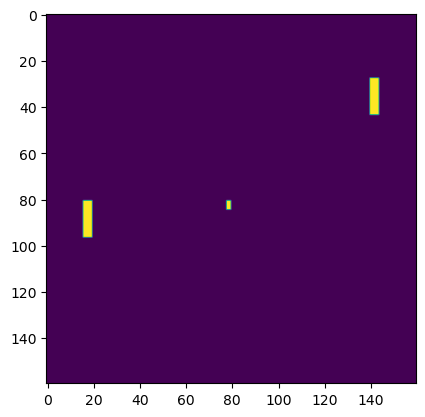

In [3]:
def state_preprocess(s):
    s = s[34: -16, : ] / 255  # ETALON  s = s[34: -16, :] / 255
    s = s.astype('float32')
    s = s.round()    
    return s


s = env.reset()[0] # RESET ENVIRONMENT
for _ in range(21):    
    a = env.action_space.sample()
    s, r, terminated, truncated, info = env.step(a) # make a STEP

s = state_preprocess(s)
print(s.shape)
print('type', type(s))
plt.imshow(s)


### Help function to show recorded game

In [4]:
def show_video():
    import glob
    import io
    import base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay

    mp4list = glob.glob('./video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        print(mp4)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

### Definition of 2 stack classes:
Exp_stack():   - The memory object to store all experience. 
            - Keeps maximal size when updated with new Step data.
            - Generates minibatches with several methods
            
Image_stack(): - Stack of preprocessed images with certain size for inference. 
            - Keeps maximal size when updated with new Step data.
            

In [5]:
# s, a, r, s1, int(s, a, r, s1, int(terminated))
class Exp_stack():
    def __init__(self, max_size = 10, batch_size = 5, inf_pack_size = 4):
        self.max_size = max_size
        self.batch_size = batch_size
        self.inf_pack_size = inf_pack_size
        self.stack = None                    
        self.full = False

    def add(self, new_row):
        # print('called')
        if self.stack is None:
            self.stack = new_row
            
        else:
            self.stack = np.vstack((self.stack, new_row)) #, axis = 0)


        self.keep_max_stack_size() # optimize buffer
        self.is_full() # set state

    def is_full(self):
        
        if (self.stack.ndim != 1) and (len(self.stack) >= self.batch_size):
            self.full = True
        else:
            self.full = False

    def keep_max_stack_size(self):
        if (self.stack.ndim != 1) and self.stack.shape[0] > self.max_size:
            self.stack = self.stack[- self.max_size :]


    def get_minibatch(self, shuffle = True, reversed = False):
        if len(self.stack) < self.batch_size:
            return None
        # GET MINIBATCH SHUFFLED
        row_indexes = np.arange(len(self.stack)) 
        if shuffle:                   
            np.random.shuffle(row_indexes)
            
        row_indexes = row_indexes[-self.batch_size : ]
        if reversed:
            return self.stack[row_indexes][:: -1]
            
        return self.stack[row_indexes]

    def reset(self):
        self.stack = None

        
    
    def get_minibatch_packed(self, shuffle = False):       
        amount_of_variants = self.stack.shape[0] -  self.inf_pack_size + 1
        if amount_of_variants > self.batch_size:
            amount_of_variants = self.batch_size
        
        
        new_row_size = amount_of_variants #self.batch_size 
        new_col_size = self.stack.shape[1]
        minibatch_pack = np.empty(shape = (new_row_size, new_col_size), dtype = object)

        available_indexes = list(range(self.stack.shape[0] -  self.inf_pack_size + 1))
        
        for i_sample in range(amount_of_variants):
            start_ixd = np.random.choice(available_indexes) # take random
            available_indexes.remove(start_ixd)             # delete it to avoid doubles
            tmp_arr = self.stack[start_ixd : start_ixd + self.inf_pack_size, :]              
            
            s_tmp = Image_stack(self.inf_pack_size)            
            s1_tmp = Image_stack(self.inf_pack_size)
            s_tmp.add_array(tmp_arr[:, 0])             
            a_tmp = tmp_arr[-1, 1]
            r_tmp = tmp_arr[-1, 2]   
            s1_tmp.add_array(tmp_arr[:, 3])            
            terminated_tmp = tmp_arr[-1, 4]
            
            minibatch_pack[i_sample] = s_tmp.pack(), a_tmp, r_tmp, s1_tmp.pack(), terminated_tmp
            
        
        if shuffle:
            row_indexes = np.arange(len(minibatch_pack)) 
            np.random.shuffle(row_indexes)
            return minibatch_pack[row_indexes]

        return minibatch_pack


    def get_last_nimibatch_pack(self, reversed = False):
        ##########################################################################
        raw_data = self.get_minibatch(shuffle = False, reversed = False)

        new_row_size = self.batch_size - self.inf_pack_size + 1
        new_col_size = raw_data.shape[1]
        minibatch_pack = np.empty(shape = (new_row_size, new_col_size), dtype = object)
        
        for i in range(self.batch_size - self.inf_pack_size + 1):
            s = Image_stack(self.inf_pack_size)
            
            s1 = Image_stack(self.inf_pack_size)
            tmp_arr = raw_data[i : i + self.inf_pack_size, :] 
            
            s.add_array(tmp_arr[:, 0]) 
            a = tmp_arr[-1, 1]
            r = r = tmp_arr[-1, 2] # <-- sum for all episode     #r = tmp_arr[-1, 2]   
            s1.add_array(tmp_arr[:, 3])
            terminated = tmp_arr[-1, 4]
            
            minibatch_pack[i] = s.pack(), a, r, s1.pack(), terminated
        ###########################################################################

        if reversed:
            return minibatch_pack[::-1]

        return minibatch_pack


    def get_solid_minibatch_from_any_place(self, reversed = True):              
        num_of_packs = self.stack.shape[0] - self.inf_pack_size + 1 # available packs to make
        
        if num_of_packs >= self.batch_size:
            tmp_batch_size = self.batch_size + self.inf_pack_size - 1
        else:
            tmp_batch_size = num_of_packs + self.inf_pack_size - 1        
        
        available_indexes = list(range(self.stack.shape[0] - tmp_batch_size + 1)) # list of available indexes        
           
        new_row_size = tmp_batch_size - self.inf_pack_size + 1 #output size
        new_col_size = self.stack.shape[1]
        minibatch_pack = np.empty(shape = (new_row_size, new_col_size), dtype = object)        
        
        start_ixd = np.random.choice(available_indexes) # take random
        available_indexes.remove(start_ixd)             # delete it to avoid doubles

        for row_num in range(new_row_size):
            tmp_arr = self.stack[start_ixd + row_num: start_ixd + row_num + self.inf_pack_size, :]   
            s_tmp = Image_stack(self.inf_pack_size)            
            s1_tmp = Image_stack(self.inf_pack_size)
            s_tmp.add_array(tmp_arr[ : , 0])             
            a_tmp = tmp_arr[-1, 1]
            r_tmp = tmp_arr[-1, 2]  
            s1_tmp.add_array(tmp_arr[ : , 3])            
            terminated_tmp = tmp_arr[-1, 4]
            
            minibatch_pack[row_num] = s_tmp.pack(), a_tmp, r_tmp, s1_tmp.pack(), terminated_tmp
            
        
        if reversed:
            return minibatch_pack[::-1]

        return minibatch_pack


class Image_stack():
    def __init__(self, max_size = 4):
        self.max_size = max_size        
        self.stack = list()
        self.full = False

    def add(self, new_row):        
        self.stack.append(new_row)

        self.keep_max_stack_size() # optimize buffer
        self.is_full() # set state

    def add_array(self, array):
        for elem in array:
            self.stack.append(elem)
            self.keep_max_stack_size() # optimize buffer
            self.is_full() # set state

    def is_full(self):
        if len(self.stack) == self.max_size:
            self.full = True
        else:
            self.full = False

    def keep_max_stack_size(self):
        
        if len(self.stack) > self.max_size:           
            self.stack = self.stack[-self.max_size : ]


    def pack(self, forward_order = True):  # ORIGINALLY forward_order = True !!!!!!!!!!!!
        if self.full:
            tmp_list = [image[..., None] for image in self.stack]
            if forward_order:
                res = np.concatenate(tmp_list, axis = 2, dtype=np.float32)
            else:
                res = np.concatenate(tmp_list[::-1], axis = 2, dtype=np.float32)
                
            return res

        return None

    def reset(self):
        self.stack = list()



### Visualization of probability to generate a random action

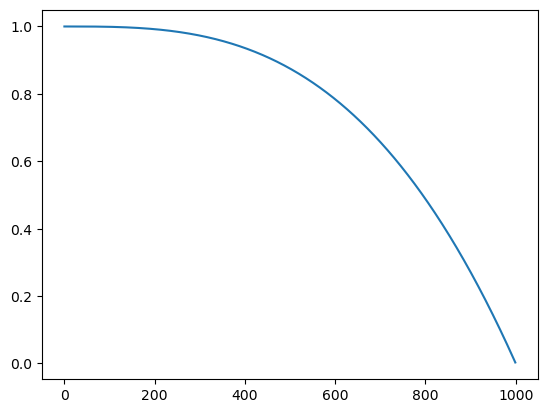

In [7]:
story = list()
num = 1000
for i in range(num):
    eps =  1.0 -   (i / num)**(3)
    story.append(eps)

plt.plot(story)

### Define the classes of DQN-network and Bot

In [7]:
class DQN():
    def __init__(self, frame_size = (160, 160, 4), lr = 0.000025):

        self.frame_size = frame_size # inference size
        self.lr = lr
        self.loss = tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.keras.optimizers.SGD(learning_rate = self.lr)
        self.model = None



    def build_model(self):    
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(8, 8),     
                                         activation='relu', 
                                         input_shape = self.frame_size,
                                         data_format = 'channels_last'   
                                        ))                
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5),                                          
                                         activation='relu'                                        
                                        ))        
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), 
                                         activation='relu'
                                        ))              
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer= 'he_uniform'))
        model.add(tf.keras.layers.Dense(512, activation='relu', kernel_initializer= 'he_uniform'))
        model.add(tf.keras.layers.Dense(NUM_ACTIONS, activation= 'linear', kernel_initializer= 'he_uniform'))
        model.compile(loss = self.loss, optimizer = self.optimizer)
        self.model =  model

    def evalQ_single(self, s):
        inp = s[None, ...]
        return self.model(inp).numpy()[0]
    
    def evalQ_batch(self, s):
        return self.model(s).numpy()





class Bot():
    def __init__(self, 
                 env = env,
                 num_episodes = 1000,
                 max_steps = 1000, # steps per episode
                 frame = Image_stack(4), 
                 experience_stack = Exp_stack(max_size = 1000, batch_size = 16, inf_pack_size = 4)  , 
                 dqn = None,
                 gamma = 0.99
                ):

        self.env = env
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.frame = frame
        self.experience_stack = experience_stack
        self.dqn = dqn
        self.gamma = gamma

        self.current_epizode = 0
        self.current_step = 0

        self.tmp_q_target = None


    def get_eps(self):
        return 1.0 - ( self.current_epizode / self.num_episodes)**(3)
        

    def play_epizode_collect_data(self):

        s = self.env.reset()[0] # RESET ENVIRONMENT
        s = state_preprocess(s) # make it shape = (160,160,3) and scale values to [0, 1]

        totalReward = 0
        self.current_step = 0
        while self.current_step < self.max_steps:
            self.current_step += 1 

            #########################################
            # GET ACTION 
            if (not self.frame.full) or (np.random.rand() < self.get_eps()): 
                a = self.env.action_space.sample()           # get random action
                
            else:                                            # get action from Q function
                s_pack = self.frame.pack()                   # get package of several images
                Q_s_sample = self.dqn.evalQ_single(s_pack)   # get vector of probabilities of ACTION
                a = np.argmax(Q_s_sample)                    # choose the Action by current policy       
                
            #########################################

            s1, r, terminated, truncated, info = self.env.step(a) # make a STEP
            s1 = state_preprocess(s1)

            #################################################
            # SAVE EXPERIENCE 
            self.experience_stack.add(np.array([s, a, r, s1, terminated], dtype = object))
            #################################################

            totalReward += r                                 # increment of REWARD        
            s = copy.deepcopy(s1)                            # APPLY NEW VALUE FOR NEXT ITERATION    
                                                             
            if terminated:                                   # end of episode
                break  
        
        return totalReward

    def train_on_collected_data(self, train_cycles = 1000, ironing = False):
        for i_cycle in range(train_cycles):
                
            #################################################
            # TRAIN Q FUNCTION on BINIBATCH 
            if self.experience_stack.full:

                if ironing:
                    minibatch_pack = self.experience_stack.get_solid_minibatch_from_any_place(reversed = True) # consequent batch from random place of the memory. must be reversed
                    s1_of_first_row = minibatch_pack[0, 3]
                    Q_s1_of_first_row = self.dqn.evalQ_single(s1_of_first_row)
                else:
                    minibatch_pack = self.experience_stack.get_minibatch_packed(shuffle = False) # from random places
                    s1_batch = np.array([elem for elem in minibatch_pack[:, 3]], dtype=np.float32)
                    Q_s1 = self.dqn.evalQ_batch(s1_batch) # calc for batch of S1

                
                s_batch = np.array([elem for elem in minibatch_pack[:, 0]], dtype=np.float32)

                Q_s = self.dqn.evalQ_batch(s_batch)  # calc for batch of S
        
                # NEW value of Q-function
                Q_target = copy.deepcopy(Q_s)
                
                for row in range(minibatch_pack.shape[0]):                
                    if minibatch_pack[row, 4] == True: # if DONE
                        # print('DONE')
                        Q_target[row, minibatch_pack[row, 1]] = minibatch_pack[row, 2] # Q_target[a] = r
                        
                    else:
                        if ironing:
                            if row == 0:
                                Q_target[row, minibatch_pack[row, 1]] = minibatch_pack[row, 2] + self.gamma * np.max(Q_s1_of_first_row) # Q_target[a] = r + gamma * np.max(Q_s1)
                            else:
                                Q_target[row, minibatch_pack[row, 1]] = minibatch_pack[row, 2] + self.gamma * np.max(Q_target[row-1]) #apply [gamma * reward] of reward from previous iteration 
                            
                        else:    
                            Q_target[row, minibatch_pack[row, 1]] = minibatch_pack[row, 2] + self.gamma * np.max(Q_s1[row]) # Q_target[a] = r + gamma * np.max(Q_s1)
                        
                              
                self.tmp_q_target = Q_target # just for case
                
                # Update of Q-function
                inp = np.array([elem for elem in minibatch_pack[:, 0]], dtype=np.float32)
                self.dqn.model.train_on_batch(inp, Q_target) 
        
  
    def play_game(self, play_steps = 1000):
        
        env_sim = RecordVideo(self.env, './video',  episode_trigger = lambda episode_number: True)
        frame = Image_stack(FRAME_STACK_SIZE) # USED FOR EVERY STEP TO GET AN ACTION
        
        
        s = env_sim.reset()[0] # RESET ENVIRONMENT
        s = state_preprocess(s) # make it shape = (160,160,3) and scale values to [0, 1]
        totalReward = 0
        
        
        for _ in range(play_steps):
            frame.add(s) # <-- arr of STATES
            
            #########################################
            # GET ACTION 
            if (not frame.full): 
                a = env_sim.action_space.sample()     # get random action               
                
            else: # get action from Q function
                s_pack = frame.pack()             # get package of several images   
                Q_s_sample = self.dqn.evalQ_single(s_pack) # get vector of probabilities of ACTION                
                a = np.argmax(Q_s_sample)         # choose the Action by current policy                
            #########################################
            
            s1, r, terminated, truncated, info = env_sim.step(a) # make a STEP
            s1= state_preprocess(s1)
        
            s = copy.deepcopy(s1)       
            totalReward += r

            if terminated:
                break
        
        env_sim.close()     
        show_video()
        return totalReward

    
    def big_training(self, train_cycles = 20):       
        
        reward_history = list()   
        self.current_epizode = 0
        
        for self.current_epizode in range(self.num_episodes):
            # print('epizode', self.current_epizode)
            round_reward = self.play_epizode_collect_data()
            reward_history.append(round_reward)
            

            # self.train_on_collected_data(train_cycles = train_cycles, ironing = True) # fast teach, but rude
           
            self.train_on_collected_data(train_cycles = train_cycles, ironing = False) # slow but more precise
            
            if self.current_epizode % 10 == 0:
                display.clear_output(wait=True)
                just_play_reward = self.play_game(play_steps = 500)

        print('finished')
                


### Definition of Global parameters
### Creation of Global Objects

In [12]:
NUM_EPISODES = 10000         # NUMBER OF EPISODES TO TRAIN
MAX_STEPS = 10000           # MAXUMAL AMOUNT OF STEPS PER EPISODE
REWARD_AVERAGE_WINDOW = NUM_EPISODES // 10 # окно для усреднения наград по эпизодам

FRAME_STACK_SIZE = 4        # num images in stack for inference
FRAME_SIZE = (160, 160, FRAME_STACK_SIZE)

EXP_STACK_SIZE = 30000      # MAXIMAL NUMBER OF ELEMENTS IN MEMORY STACK
EXP_MINIBATCH_SIZE = 16 #6

GAMMA = 0.99                # DISCOUNTING PARAMETER
LEARNING_RATE = 0.00025     # 0.00025 
###########################################

###########################################
# CREATE GLOBAL OBJECTS

# MEMORY STACK. ACCRUES ALL STEPS DATA. MAKES ZIP several IMAGES of several steps to Tensor 
experience_stack = Exp_stack(max_size = EXP_STACK_SIZE,  
                             batch_size = EXP_MINIBATCH_SIZE,
                             inf_pack_size = FRAME_STACK_SIZE) # conneclion of S, A, R, S1, DONE chains

# FRAME. Image stack for inference # USED FOR EVERY STEP TO GET AN ACTION
frame = Image_stack(FRAME_STACK_SIZE) 

# CREATE and BUILD DQN model
dqn = DQN(frame_size = FRAME_SIZE, lr = LEARNING_RATE) # Deep Q Net object
dqn.build_model()

# CREATE GAME INVIRONMENT
env = gym.make('Pong-v4', render_mode="rgb_array", obs_type="grayscale") # Game environment

In [13]:
# CREATE BOT 
bot = Bot(env = env,  
             num_episodes = NUM_EPISODES,
             max_steps = MAX_STEPS, # steps per episode
             frame = frame, experience_stack = experience_stack,
             dqn = dqn,
             gamma = GAMMA
            )


In [11]:
bot.dqn.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 153, 153, 32)      8224      
                                                                 
 conv2d_1 (Conv2D)           (None, 149, 149, 64)      51264     
                                                                 
 conv2d_2 (Conv2D)           (None, 147, 147, 64)      36928     
                                                                 
 flatten (Flatten)           (None, 1382976)           0         
                                                                 
 dense (Dense)               (None, 128)               177021056 
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dense_2 (Dense)             (None, 6)                 3

### Train bot on DQN
#### Bot saves [S, A, R, S1, DONE] chains into MEMORY stack
#### Uses data from MEMORY stack to train Q function
#### Periodically plays an EPISODE based on DQN data only (without random actions) and shows recorded video

In [7]:
bot.big_training(train_cycles = 100)

./best.mp4


finished


In [15]:
# SAVE the weights using the `checkpoint_path` format
# checkpoint_path = "training_day4_160_160_4/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# # Save the weights using the `checkpoint_path` format
# dqn.model.save_weights(checkpoint_path.format(epoch=0))

In [9]:
#LOAD WEIGHTS
# checkpoint_path = "training_day3_160_160_4/cp.ckpt" # size 160x160x4
# checkpoint_dir = os.path.dirname(checkpoint_path)

# latest = tf.train.latest_checkpoint(checkpoint_dir)
# # latest)qq
# # Load the previously saved weights
# dqn.model.load_weights(latest)
